# Predictive Maintenance: Notebook Overview

This notebook builds and evaluates convolutional and LSTM-based models for Remaining Useful Life (RUL) prediction.
It loads preprocessed datasets, defines model architectures and evaluation metrics, performs randomized and local hyperparameter search,
then trains, evaluates, and finally extracts the best model's parameters.

Tip: run cells top to bottom; adjust dataset paths in constants if needed.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pickle
import time
import os
from constants import dataset_conv_name, dataset_lstm_name

In [ ]:

model=tf.keras.models.load_model('LSTM_12-14-15-16_17.h5')   
predictions = np.ravel(model.predict(X))

**Model Definitions**

Defines two architectures:
- `model_conv_lstm(Tx, nh, nw, nchan, ...)`: time-distributed Conv2D feature extractor over sequences, followed by LSTM and dense heads for per-timestep RUL regression.
- `model_conv2D(nh, nw, nchan, ...)`: pure 2D convolutional baseline with a dense regression head.

Tuneable knobs include conv width (`size_conv`), LSTM units (`size_lstm`), dense size, strides, activations, and dropout.


In [ ]:
def model_conv_lstm(Tx, nh, nw, nchan, size_conv, size_lstm,
                    size_dense, drop, drop_1, activations, size_stride):
      
      inputs =Input(shape=(Tx,nh,nw,nchan))                                                         
      X = TimeDistributed(Conv2D(int(nchan*size_conv)+1, 5, int(size_stride[0]),padding="same", activation=activations[0]))(inputs)  #padding done so that it returns to the original dimensions
      X=Dropout(drop)(X)                 
      X=BatchNormalization()(X)          
      X=TimeDistributed(MaxPool2D(2))(X)  #uses time-distributed MaxPooling with filter size 2 (stride of 2 by default)
      X=TimeDistributed(Conv2D(int(nchan*size_conv*1.5),3,int(size_stride[1]), activation=activations[1]))(X)   # applies time distributed Conv2D in such a way that weights are the same for all the Tx elements
      X=Dropout(drop)(X)
      X=BatchNormalization()(X)
      X=TimeDistributed(MaxPool2D(3))(X) 
      X=TimeDistributed(Conv2D(int(nchan*size_conv*2.25),3,int(size_stride[2]), activation=activations[2]))(X) 
      X=Dropout(drop)(X)
      X=BatchNormalization()(X)
      X =TimeDistributed(MaxPool2D(2))(X)
      X=TimeDistributed(Flatten())(X)  #flatten the matrix so that the elements can be input into the LSTM
      X=LSTM(size_lstm,return_sequences=True)(X)                                 
      X=BatchNormalization()(X)
      X=Dropout(drop)(X)
      X = TimeDistributed(Dense(size_dense+1, activation = activations[3]))(X)  
      X=BatchNormalization()(X)
      X=Dropout(drop_1)(X)
      outputs = TimeDistributed(Dense(1, activation = "linear"))(X)          

      model = keras.Model(inputs=inputs, outputs=outputs)
      return model

def model_conv2D(nh,nw,nchan,size_conv,size_dense,drop,drop_1,activations,size_stride):
  inputs = Input(shape=(nh,nw,nchan))
  X = Conv2D(int(nchan*size_conv)+1, 5, int(size_stride[0]),padding="same", activation=activations[0])(inputs)
  X=Dropout(drop)(X)
  X=BatchNormalization()(X)
  X=MaxPool2D(2)(X)
  X = Conv2D(int(nchan*size_conv*1.5), 2, int(size_stride[1]), activation=activations[1])(X)
  X=Dropout(drop)(X)
  X = BatchNormalization()(X)
  X=MaxPool2D(3)(X)
  X = Conv2D(int(nchan*size_conv*2.25), 3, int(size_stride[2]),activation=activations[2])(X)
  X=Dropout(drop)(X)
  X = BatchNormalization()(X)
  X=MaxPool2D(2)(X)
  X = Flatten()(X)
  X = Dense(size_dense+1, activations[3])(X)
  X=Dropout(drop_1)(X)                                               
  X = BatchNormalization()(X)
  outputs=Dense(1, activation="linear")(X)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model


In [ ]:
conv = True

if conv:
    with open(dataset_conv_name, "rb") as fp:
        [X_train, Y_train, X_test, Y_test]=pickle.load(fp)
    a,nh,nw,nch=X_train.shape
    
else:
    with open(dataset_lstm_name, "rb") as fp:
        [X_train, Y_train, X_test, Y_test]=pickle.load(fp)
    a,max_l, nh, nw, nch = X_train.shape
    model = model_conv_lstm(max_l,nh,nw,nch)

pad=0
Y_train[Y_train==0]=pad
Y_test[Y_test==0]=pad



**Score Definitions**

- `norm_MAE`: normalized MAE and absolute MAE, excluding padding 0s.
- `MAPE`: mean absolute percentage error.
- `rel_score`: penalty for overestimations (predicted RUL > true), weighted more near end-of-life.
- `norm_std`: normalized std of absolute error and a percentage error trace for plotting.
- `agg_score`: weighted aggregate of the above (MAPE prioritized).


In [ ]:
def norm_MAE(Y, predictions):

    real_predictions = predictions[Y!=pad]                                           #do not consider predictions on padding to 0
    real_Y = Y[Y!=pad]
    MAE = np.average(np.abs(real_Y-real_predictions))
    mae = np.average(np.abs(real_Y-real_predictions))/(np.average(real_Y))                        
    return mae, MAE


def MAPE(Y,predictions):

    real_predictions = predictions[Y!=pad]                                           
    real_Y = Y[Y != pad]
    mape = np.average(np.abs(real_Y - real_predictions)/np.abs(real_Y))                          
    return mape

#score that penalizes models that generally return higher RUL than the ground truth
def rel_score(Y, predictions):

    real_predictions = predictions[Y!=pad]
    real_Y = Y[Y!=pad]
    tot = (np.array([real_Y, real_predictions])).T                               #create a single vector to better manage sorting
    tot=np.flipud(tot[tot[:,0].argsort()])                                     
    real_Y=tot[:,0]
    real_predictions=tot[:,1]
    range_=0.50
    vec=np.zeros(real_Y.size)
    for i in range (real_Y.size):
        vec[i]=np.power(1.1,i)                                                   #creates a weight vector that will constitute the score

    x=(range_*(np.amax(vec)))/np.sum(vec)
    vec=x/vec
    vec=np.flip(vec)
    sum_score=0

    a= real_Y - real_predictions
    for i in range (real_Y.size):
        if a[i]<0:                                                               #if not==> penalty
            sum_score=sum_score+vec[i]
    return sum_score

#definition of a score that evaluates the normalized standard deviation of the error
def norm_std(Y, predictions):

    real_predictions = predictions[Y!=pad]
    real_Y = Y[Y!=pad]
    err = np.abs(real_Y - real_predictions)
    graph = (err/real_Y)*100                                                       #save the values that will make up a graph in graph
    std = np.std(err)
    prec = std/(np.average(real_Y))
    return prec, graph

#definition Score that summarizes the previous ones, giving more importance to MAPE
def agg_score(Y,predictions):

    w_mape = 2/3
    w_prec = 1/6
    w_rel_sc = 1/6
    prec, graph = norm_std(Y,predictions)
    score = w_prec*prec+w_rel_sc*rel_score(Y, predictions) + w_mape*MAPE(Y, predictions)
    return score

**Randomized Search**

Defines two functions:
- `randomized_search_1()`: global sampling of learning rate, conv/LSTM sizes, dense width, dropout, activations, epochs, and strides.
- `randomized_search_2(...)`: local refinement around the current best.

Used to propose hyperparameters for model training.


In [ ]:
def randomized_search_1():

  exp = -3*np.random.rand()-1
  alpha = np.power(10,exp)                          

  size_conv = np.random.rand()+1                     #number that enlarges the number of units in all convolutional layers accordingly 
  size_lstm = np.random.choice([16,32,64,128])       
  size_dense = int(np.abs((np.random.normal(10,2))))  
  activations = np.random.choice(["relu","tanh"],4)

  choice = np.random.rand()
  if choice < 0.5:                                
    drop = 0
  else:
    drop=np.random.rand()
  if drop == 0:
    drop_1 = 0
  else:
    drop_1 = np.abs(drop-0.1)                      #the dropout for the last layer is slightly lower
                 
  epo = int(np.random.uniform(400,900))
  size_stride = np.random.choice([1,2],3)

  return alpha, size_conv, size_lstm,size_dense, drop, drop_1, activations, epo, size_stride

def randomized_search_2(alpha_1, size_conv_1,size_dense_1, drop_1, activations_1, epo_1):

  alpha = np.random.uniform(0.5*alpha_1, 1.5*alpha_1 )

  size_conv = np.abs(np.random.normal(size_conv_1,0.2))
  size_dense = int(np.abs((np.random.normal(size_dense_1,1))))

  if drop_1 == 0:
    drop=np.random.rand()
  else:
    drop=np.random.uniform(0.9*drop_1, 1.1*drop_1)
    if drop >= 1:                                            
      drop = 0.95
  drop_1_1 = np.abs(drop-0.1)

  if np.sum(activations_1=='relu')>2:
    activations=np.random.choice(["relu","tanh"],4,p=[0.7,0.3]) 
  elif np.sum(activations_1=='relu')==2:
    activations=activations_1
  else:
    activations=np.random.choice(["relu","tanh"],4,p=[0.3,0.7])

  epo=int(np.random.uniform(0.85*epo_1,1.15*epo_1))
  if epo>1000:                                           
    epo=1000

  return alpha, size_conv, size_dense, drop, drop_1_1, activations, epo

**Train the Model**

High-level training orchestration with time budgets:
- Part 1: broad search over random configs with Conv+LSTM when `conv` is False.
- Part 2: local search around the best configuration.

Tracks `min_score` using `agg_score` on the test set.


**Local Search: Conv + LSTM**

Iterates candidate hyperparameters, compiles with Adam, trains for `epo` epochs, evaluates on `Y_test`, and saves the best LSTM model by aggregate score.


In [ ]:
lstm_model_name = ""
min_score = 100                                                                    
i = 1
flag = True
start = time.time()
if not conv:
  while(time.time() - start < 10800 and i < 130):                     #execute part 1 until 10,800 seconds have passed or I have evaluated more than 130 models
                                                                                
    print(i)                                                                      
    if i%10 == 0:                                                                  
      print("il MAPE vale ",MAPE(np.ravel(Y_test), np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test), np.ravel(model.predict(X_test))))
      print(alpha)
      print(size_lstm)
      print(size_dense)

    while flag == True:
      try:                                                                      
        alpha, size_conv, size_lstm,size_dense, drop, drop_1, activations, epo, size_stride = randomized_search_1()
        model = model_conv_lstm(max_l, nh, nw, nch, size_conv, size_lstm,
                                 size_dense, drop, drop_1, activations, size_stride)
        flag = False
      except:                                                                    #if it fails due to inconsistencies in the model dimensions==>try again
        flag = True
    flag = True
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=opt, loss='mean_squared_error')
    history=model.fit(X_train, Y_train, 
                      batch_size=5, epochs=epo, verbose=0)             
    i=i+1
    predictions=np.ravel(model.predict(X_test))

    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1, size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1 = alpha, size_conv, size_lstm, size_dense, drop, drop_1, activations, epo, size_stride
      model.save(lstm_model_name)                                   
    
  i=1     
  start=time.time() 
  while(time.time()-start<7200 and i <90):                                        #execute part 2 until 7200 seconds have passed or I have evaluated more than 90 models

    print(i)
    if i%10==0:
      print("il MAPE vale ", MAPE(np.ravel(Y_test), np.ravel(model.predict(X_test))))
      print("L'agg score vale ", agg_score(np.ravel(Y_test), np.ravel(model.predict(X_test))))
      print(alpha)
      print(size_lstm)
      print(size_dense)

    alpha, size_conv,size_dense, drop, drop_1, activations, epo = randomized_search_2(alpha_1, size_conv_1, size_dense_1,
                                                                                       drop_1,activations_1, epo_1)
    model= model_conv_lstm(max_l, nh, nw, nch, size_conv, 
                           size_lstm_1, size_dense, drop, 
                           drop_1, activations, size_stride_1)
    opt = keras.optimizers.Adam(learning_rate = alpha)
    model.compile(optimizer = opt, loss = 'mean_squared_error')
    history=model.fit(X_train, Y_train,
                     batch_size=5, epochs=epo,
                    verbose=0)
    i=i+1
    predictions = np.ravel(model.predict(X_test))

    if agg_score(np.ravel(Y_test), predictions) < min_score:

      min_score = agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1 = alpha, size_conv, size_lstm_1,size_dense,drop, drop_1, activations, epo, size_stride_1
      model.save(lstm_model_name)


**Local Search: Convolutional**

Same local-search strategy for the pure Conv2D model when `conv` is True.


In [ ]:
conv_model_name = ""
min_score = 100
i = 1
flag = True
start=time.time()
if conv:

  while(time.time() - start<10800 and i <130):

    print(i)
    if i%10==0:
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))

    while flag==True:

      try:
        alpha, size_conv, size_lstm, size_dense, drop, drop_1, activations, epo, size_stride = randomized_search_1()
        model = model_conv2D(nh, nw, nch, size_conv,
                              size_dense, drop, drop_1,
                              activations, size_stride)
        flag=False
      except:
        flag=True
    flag=True
    opt = keras.optimizers.Adam(learning_rate = alpha)
    model.compile(optimizer = opt, loss='MAPE')
    history=model.fit(X_train, Y_train, batch_size=64,
                       epochs=epo, verbose=0)
    i=i+1
    predictions=np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions)<min_score:
      min_score=agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1 = alpha, size_conv, size_lstm,size_dense,drop, drop_1, activations, epo, size_stride
      model.save(conv_model_name) 
  i=1    
  start=time.time() 
  while(time.time() - start<7200 and i<90):

    print(i)
    if i%10==0:
      print("il MAPE vale ",MAPE(np.ravel(Y_test),np.ravel(model.predict(X_test))))
      print("L'agg score vale ",agg_score(np.ravel(Y_test),np.ravel(model.predict(X_test))))

    alpha, size_conv,size_dense, drop, drop_1, activations, epo = randomized_search_2(alpha_1, size_conv_1,
                                                                                       size_dense_1, drop_1,
                                                                                         activations_1, epo_1)
    model = model_conv2D(nh, nw, nch, size_conv, size_dense,
                          drop, drop_1, activations, size_stride_1)
    opt = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer = opt, loss = 'MAPE')
    history = model.fit(X_train, Y_train,
                         batch_size=64, epochs=epo, verbose=0)
    i = i+1
    predictions = np.ravel(model.predict(X_test))
    if agg_score(np.ravel(Y_test),predictions) < min_score:
      min_score = agg_score(np.ravel(Y_test),predictions)
      alpha_1, size_conv_1, size_lstm_1,size_dense_1, drop_1, drop_1_1, activations_1, epo_1, size_stride_1 = alpha, size_conv, size_lstm_1, size_dense, drop, drop_1, activations, epo, size_stride_1
      model.save(conv_model_name)

**Best Model Statistics**

Loads the best model, runs predictions on `X_test`, clips negatives to 0, and plots/prints summary metrics.


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
1.0381188730208257
0.32520034174656254
0.46681384558495415
  
0.8240816132358033


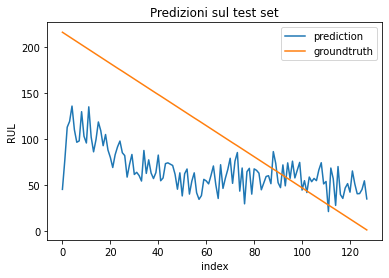

 
il MAE vale  55.743544373512265


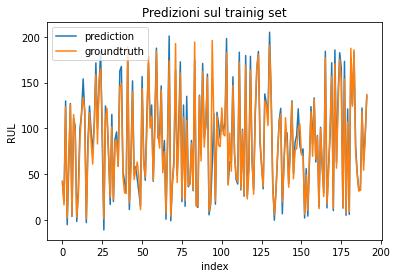

0.2260008516922248
 


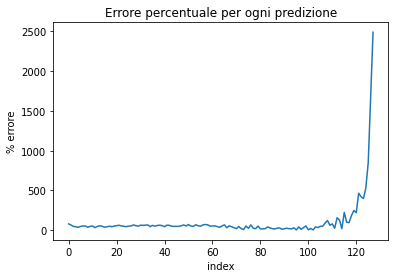

In [ ]:
best_model = ""
predictions = np.ravel(best_model.predict(X_test))
predictions[predictions<0] = 0                                                     #if I predict a negative number==> make it null for consistency
if conv:                                                                       
  predictions = predictions[np.flip(Y_test.argsort())]
  Y_test = np.flip(np.sort(Y_test))

print(MAPE(np.ravel(Y_test),predictions))
prec, graph = norm_std(np.ravel(Y_test),predictions)
print(prec)
print(rel_score(np.ravel(Y_test),predictions))
print("  ")
print(agg_score(np.ravel(Y_test),predictions))

plt.plot(predictions,label="prediction")
plt.plot(np.ravel(Y_test),label="groundtruth")
plt.legend()
plt.ylabel('RUL')
plt.xlabel('index')
plt.title('Predizioni sul test set')
plt.show()
print(" ")

mae, MAE = norm_MAE(np.ravel(Y_test), predictions)
print("il MAE vale ", MAE)

if not conv:
  for i in range (a):  
    predictions_tr=np.ravel(best_model.predict(X_train)[i,:,:])
    plt.plot(predictions_tr,label="prediction")
    plt.plot(np.ravel(Y_train[i,:]),label="groundtruth")
    plt.legend()
    plt.ylabel('RUL')
    plt.xlabel('index')
    plt.show()

if conv:             
  predictions_tr=np.ravel(best_model.predict(X_train))
  plt.plot(predictions_tr,label="prediction")
  plt.plot(np.ravel(Y_train),label="groundtruth")
  plt.legend()
  plt.ylabel('RUL')
  plt.xlabel('index')
  plt.title('Predizioni sul trainig set')
  plt.show()
  
predictions_tr=np.ravel(best_model.predict(X_train))
print(MAPE(np.ravel(Y_train),predictions_tr))
print(" ")

plt.plot(graph)
plt.ylabel('% errore')
plt.xlabel('index')
plt.title('Errore percentuale per ogni predizione')
plt.show()

**Retraining & Loss Curve**

Optional: clone the best model and retrain to inspect how the training loss evolves across epochs (to validate convergence and detect overfitting).


In [ ]:
if not conv:
  batch = 2
else:
  batch= 64
best_model_training = keras.models.clone_model(best_model)
alpha = (best_model.optimizer.get_config()).get("learning_rate")
opt = keras.optimizers.Adam(learning_rate = alpha)
best_model_training.compile(optimizer = opt, loss = 'mean_squared_error')
history = best_model_training.fit(X_train, Y_train, 
                                batch_size=batch, 
                                epochs=500, verbose=0)
loss=history.history['loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs,loss)
plt.ylabel('Training loss (MSE)')
plt.xlabel('epochs')
plt.show()

**Retrieve Best LSTM Model Parameters**

Extracts layer configuration (activations, filters, strides, dropout, units) from the selected LSTM-based model.


In [ ]:
if not conv:

  list_layer = list((best_model.get_config()).get('layers'))
  activ=[]; filt=[]; strid=[]; rate=[]; uni_lstm=0; uni_dense=0
  #1 conv 2d
  activ = activ + [((((list_layer[1]).get('config')).get('layer')).get('config')).get('activation')]
  filt = filt + [((((list_layer[1]).get('config')).get('layer')).get('config')).get('filters')]
  strid = strid + [((((list_layer[1]).get('config')).get('layer')).get('config')).get('strides')]

  #1 dropout
  rate = rate + [((list_layer[2]).get('config')).get('rate')]

  #2 conv 2d
  activ = activ + [((((list_layer[5]).get('config')).get('layer')).get('config')).get('activation')]
  filt = filt + [((((list_layer[5]).get('config')).get('layer')).get('config')).get('filters')]
  strid = strid + [((((list_layer[5]).get('config')).get('layer')).get('config')).get('strides')]

  #3 conv 2d
  activ = activ + [((((list_layer[9]).get('config')).get('layer')).get('config')).get('activation')]
  filt = filt + [((((list_layer[9]).get('config')).get('layer')).get('config')).get('filters')]
  strid = strid + [((((list_layer[9]).get('config')).get('layer')).get('config')).get('strides')]

  #LSTM
  uni_lstm = ((list_layer[14]).get('config')).get('units')
  #2 dropout
  rate = rate + [((list_layer[19]).get('config')).get('rate')]
  #1 dense
  uni_dense = ((((list_layer[17]).get('config')).get('layer')).get('config')).get('units')
  activ = activ + [((((list_layer[17]).get('config')).get('layer')).get('config')).get('activation')]

  alpha = (best_model.optimizer.get_config()).get("learning_rate")

**Retrieve Best Convolutional Model Parameters**

Extracts layer parameters from the selected Conv2D-only model.


In [ ]:
if conv:
  list_layer = list((best_model.get_config()).get('layers'))
  activ=[]; filt=[]; strid=[]; rate=[]; uni_lstm=0; uni_dense=0
  #1 conv 2d
  activ = activ + [((list_layer[1]).get('config')).get('activation')]
  filt = filt + [((list_layer[1]).get('config')).get('filters')]
  strid = strid + [((list_layer[1]).get('config')).get('strides')]

  #1 dropout
  rate = rate + [((list_layer[2]).get('config')).get('rate')]

  #2 conv 2d
  activ = activ + [((list_layer[5]).get('config')).get('activation')]
  filt = filt + [((list_layer[5]).get('config')).get('filters')]
  strid = strid+[((list_layer[5]).get('config')).get('strides')]

  #3 conv 2d
  activ = activ+[((list_layer[9]).get('config')).get('activation')]
  filt = filt+[((list_layer[9]).get('config')).get('filters')]
  strid = strid+[((list_layer[9]).get('config')).get('strides')]
  #1 dense
  uni_dense = ((list_layer[14]).get('config')).get('units')
  activ = activ + [((list_layer[14]).get('config')).get('activation')]
  #2 dropout
  rate = rate + [((list_layer[15]).get('config')).get('rate')]

  alpha = (best_model.optimizer.get_config()).get("learning_rate")